In [1]:
import numpy as np
import sys
sys.path.append("../code/")
from structure import *
from algo import *
from basic import *
from analysis import *
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from autograd.numpy import linalg as LA
import pickle
import itertools
from itertools import product
import calendar
from sklearn.metrics import mean_squared_error
%load_ext autoreload
%autoreload 2
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import numpy as np
import matplotlib
matplotlib.rcParams['ps.useafm']=True
matplotlib.rcParams['pdf.use14corefonts']=True
matplotlib.rcParams['text.usetex']=True

In [2]:
year=2015
tensor, hid = get_tensor(year, 'artificial')
order = APP_NAME_OBSERVED

In [3]:
# pd.DataFrame(improved_rate).plot(ax=ax[2], style='.-', title='updated season factor with regularization')
ind = [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]
month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


In [4]:
year = 2015
result = {}
result['Random'] = np.load("../data/best-result-{}-{}.npy".format(year, 'random')).item()
result['Current '] = np.load("../data/best-result-{}-{}-{}.npy".format(year, 'active', 'current')).item()
result['Current + Future'] = np.load("../data/best-result-{}-{}.npy".format(year, 'active', 'future_weighted')).item()
result['History + Current + Future '] = np.load("../data/best-result-{}-{}.npy".format(year, 'active', 'prev_future_weighted')).item()
# result['VBI-Variance'] = np.load("../data/best-result-{}-{}.npy".format(year, 'vb-new')).item()

In [5]:
mean = {}
for method in result.keys():
    mean[method] = pd.DataFrame(result[method]).mean(axis=1)

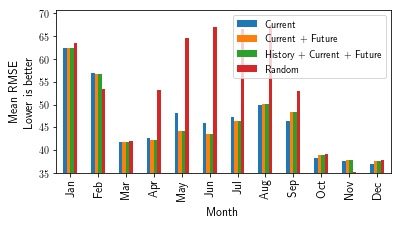

In [6]:
ax = pd.DataFrame(mean).plot(kind='bar', figsize=(6, 3))

ax.set_xlabel("Month", fontsize=12)
ax.set_xticks(ind)
ax.set_xticklabels(month, rotation=90, fontsize=12)
ax.set_ylabel("Mean RMSE \n Lower is better", fontsize=12)
ax.set_ylim(ymin=35)

fig = ax.get_figure()
# fig.tight_layout()

In [7]:
rate = {}
for method in result.keys():
    rate[method] = {}
    for t in range(12):
        rate[method][t] = 100 * (1 - mean[method][t] / mean['Random'][t])
    

In [8]:
pd.DataFrame(rate).max()

Current                        31.357477
Current + Future               35.060696
History + Current + Future     35.060696
Random                          0.000000
dtype: float64

In [15]:
sp = {}
for uncertainty in ['current', 'future_weighted', 'prev_future_weighted']:
    param = np.load("../data/best-param-2015-active-{}.npy".format(uncertainty)).item()
    k, latent_dimension, lambda1, lambda2, lambda3, kernel, delta = param.split("-")
    filename = "sp-pre-none-{}-{}-{}-0.1-0.1-0.0-{}-{}-{}-{}-{}".format(uncertainty, kernel, delta, lambda1, lambda2,
                                                                                        lambda3, k, latent_dimension)
    directory = "../data/result/reg/update_season/active/2015/artificial_old/"
    full_path = directory + filename
    sp[uncertainty] = np.load(full_path)

In [16]:
def calculate_selected_appliance(sp, k, num_random):
    selected_app = np.zeros((12, len(order)))
    for random_seed in range(num_random):
        for fold_num in range(5):
            for t in range(1, 12):
                for i in range(k):
#                     print(random_seed, fold_num, t, i)
                    app_idx = sp[random_seed][fold_num][t][i][1]
                    selected_app[t][app_idx] += 1
    return selected_app

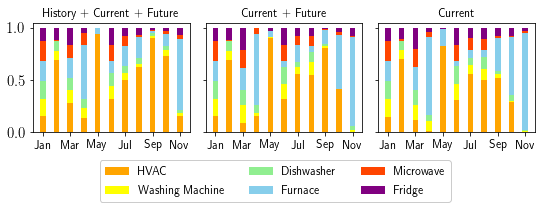

In [22]:
colors = ['gold', 'yellow', 'lightgreen', 'skyblue', 'orangered', 'purple', 'pink']
name_dict = {'current':'Current', 'future_weighted':'Current + Future', 'prev_future_weighted':'History + Current + Future'}


num_fig = len(sp.keys())
month = ['Jan', 'Mar', 'May', 'Jul', 'Sep',  'Nov']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 2), sharey=True)
ax = axes.flatten()
for n, key in enumerate(sp.keys()):
    selected_pairs = calculate_selected_appliance(sp[key], 5, 5)/(5*5*5) + 0.0001

    ind = [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]
    true_ind = [ 0,  2,  4,   6,   8,  10]
    width=0.4
    p = {}
    p[1] = ax[n].bar(ind, selected_pairs[1:, 1], width, color='orange')
    for t in range(2, 7):
        bottom = 0
        for i in range(1, t):
            bottom += selected_pairs[1:, i]
        p[t] = ax[n].bar(ind, selected_pairs[1:, t], width, bottom=bottom, color=colors[t-1])
    ax[n].set_xticks(true_ind)
    # Set the tick labels
    ax[n].tick_params(labelsize=15)
    ax[n].set_xticklabels(month, fontsize=12)
    ax[n].set_title(name_dict[key], fontsize=12)

plt.subplots_adjust(hspace=0.5, wspace=0.1)
plt.legend((p[1], p[2], p[3], p[4], p[5], p[6]), order[1:], fontsize=12, ncol=3, framealpha=1,
           fancybox=True, bbox_to_anchor=(0.5, -0.7), loc='lower right')
fig.savefig("../figure/selected_appliance_uncertainty.pdf",format='pdf', bbox_inches='tight')

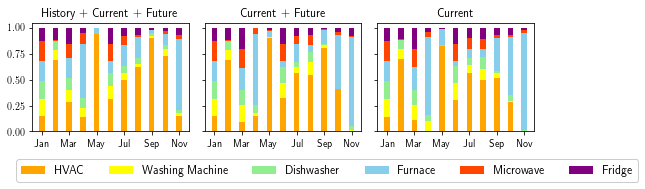

In [18]:
colors = ['gold', 'yellow', 'lightgreen', 'skyblue', 'orangered', 'purple', 'pink']
name_dict = {'current':'Current', 'future_weighted':'Current + Future', 'prev_future_weighted':'History + Current + Future'}


num_fig = len(sp.keys())
month = ['Jan', 'Mar', 'May', 'Jul', 'Sep',  'Nov']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 2), sharey=True)
ax = axes.flatten()
for n, key in enumerate(sp.keys()):
    selected_pairs = calculate_selected_appliance(sp[key], 5, 5)/(5*5*5) + 0.0001

    ind = [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]
    true_ind = [ 0,  2,  4,   6,   8,  10]
    width=0.4
    p = {}
    p[1] = ax[n].bar(ind, selected_pairs[1:, 1], width, color='orange')
    for t in range(2, 7):
        bottom = 0
        for i in range(1, t):
            bottom += selected_pairs[1:, i]
        p[t] = ax[n].bar(ind, selected_pairs[1:, t], width, bottom=bottom, color=colors[t-1])
    ax[n].set_xticks(true_ind)
    # Set the tick labels
    ax[n].set_xticklabels(month)
    ax[n].set_title(name_dict[key])

plt.subplots_adjust(hspace=0.5, wspace=0.1)
plt.legend((p[1], p[2], p[3], p[4], p[5], p[6]), order[1:], fontsize=12, ncol=6, framealpha=1,
           fancybox=True, bbox_to_anchor=(1.7, -0.2))
fig.savefig("../figure/selected_appliance_uncertainty_one_line.pdf",format='pdf', bbox_inches='tight')